In [1]:
!pip install transformers
!pip install accelerate -U


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 2.4 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.33.0
    Uninstalling accelerate-0.33.0:
      Successfully uninstalled accelerate-0.33.0


In [2]:
!pip install datasets
!pip install rouge_score
!pip install tiktoken

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0b33325d8e228c34c084980a7547cd98fb85aaa02736c7dd582a78a54fdc55cb
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00a 0:00:01


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import statistics
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TrainingArguments, Trainer
import tiktoken

In [22]:
df = pd.read_csv('/kaggle/input/qa-data/aiml-qa-train.csv',encoding='Windows-1252',header=0)  

df_selected = df[['question', 'answer']]

print(df.head())

                                            question  \
0  What is the difference between concatenation v...   
1  What is the difference between concatenation v...   
2      Why are derivatives substracted from weights?   
3      Why are derivatives substracted from weights?   
4  Describe a process/pipeline for generating rep...   

                                              answer  Unnamed: 2  Unnamed: 3  \
0  Concatenation combines two tensors by adding t...         NaN         NaN   
1  Concatenation is often used to combine differe...         NaN         NaN   
2  The derivative of the loss function at a point...         NaN         NaN   
3  The intuition behind adjusting the weights by ...         NaN         NaN   
4  Select a pretrained model suitable for the tas...         NaN         NaN   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN   

In [24]:
df_selected.columns.tolist()

['question', 'answer']

In [25]:
# find and drop 'nan' rows
print(df_selected.isnull().sum())
df_selected.dropna(subset=['question', 'answer'], inplace=True)
print(df_selected.isnull().sum())

question    0
answer      0
dtype: int64
question    0
answer      0
dtype: int64


/tmp/ipykernel_35/1352607015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.dropna(subset=['question', 'answer'], inplace=True)


In [26]:
df=df_selected

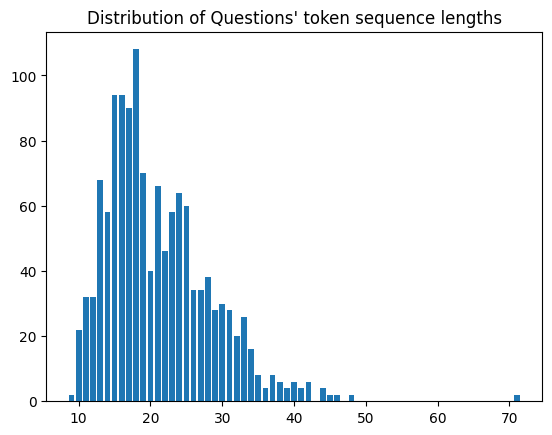

q-mean : 21.12, q-std : 7.35
q-max : 71 , q-min : 9


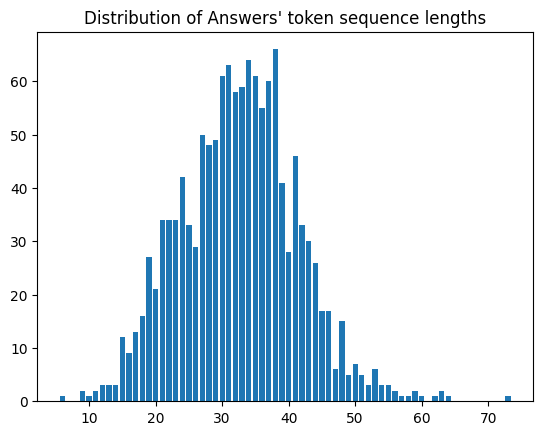

a-mean : 32.56, a-std : 8.79
a-max : 73 , a-min : 6


In [27]:
# Visualizing the dataset
data = []
for index, row in df.iterrows():
  data += [{'question': row.iloc[0], 'answer' : row.iloc[1]}]

enc = tiktoken.get_encoding("gpt2")
q = []; a = []
for qna in data:
  q.append(len((enc.encode(f"Q: {qna['question']} A: "))))
  a.append(len((enc.encode(qna['answer']))))

dq = {}; da = {}
for out in q:
  dq[out] = dq.get(out, 0) + 1
dist_q = dict(sorted(dq.items())) # sort based on keys

for out in a:
  da[out] = da.get(out, 0) + 1
dist_a = dict(sorted(da.items()))

kq = list(dist_q.keys())
vq = list(dist_q.values())

fig, ax = plt.subplots()
bars = ax.bar(kq, vq)
ax.set_title("Distribution of Questions' token sequence lengths")
plt.show()

print(f"q-mean : {statistics.mean(q):.2f}, q-std : {statistics.stdev(q):.2f}")
print(f"q-max : {max(q)} , q-min : {min(q)}")

ka = list(dist_a.keys())
va = list(dist_a.values())

fig, ax = plt.subplots()
bars = ax.bar(ka, va)
ax.set_title("Distribution of Answers' token sequence lengths")
plt.show()

print(f"a-mean : {statistics.mean(a):.2f}, a-std : {statistics.stdev(a):.2f}")
print(f"a-max : {max(a)} , a-min : {min(a)}")

In [28]:

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [29]:

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

124,439,808 total parameters.
124,439,808 training parameters.


In [38]:
pd.set_option('display.max_colwidth', None)

df.head(3)

,question,answer
0,What is the difference between concatenation vs. summation of two tensors?,Concatenation combines two tensors by adding them together along a specified dimension. Summation adds the elements of two tensors together element-wise.
1,What is the difference between concatenation vs. summation of two tensors?,"Concatenation is often used to combine different features of a data set, such as images and text. Summation is often used to calculate the similarity between two tensors, or to compute the loss function for a neural network."
2,Why are derivatives substracted from weights?,"The derivative of the loss function at a point indicates the direction of steepest descent from that point, substrating the derivative from the weights helps in finding the lowest point in the loss function."


In [41]:

input_text = "What is out-of-core learning?"
input_ids = tokenizer.encode(input_text,
                             max_length=512,
                             truncation=True,
                             return_tensors='pt',
                             ).to(device)

attention_mask = torch.ones(input_ids.shape, device=device)

outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    max_new_tokens = 50,
    top_p=0.9,
    top_k=50
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

What is out-of-core learning?

The main goal of this course is to provide a comprehensive overview of the core concepts of learning. This course is designed to be a comprehensive overview of the core concepts of learning. This course is designed to be a comprehensive overview of the core concepts


In [42]:
# split into train and val data
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print(f"train data : {len(train_data)}, val data: {len(val_data)}")
train_data[:2]

train data : 1184, val data: 132


[{'question': 'What is the difference between concatenation vs. summation of two tensors?',
  'answer': 'Concatenation combines two tensors by adding them together along a specified dimension. Summation adds the elements of two tensors together element-wise.'},
 {'question': 'What is the difference between concatenation vs. summation of two tensors?',
  'answer': 'Concatenation is often used to combine different features of a data set, such as images and text. Summation is often used to calculate the similarity between two tensors, or to compute the loss function for a neural network.'}]

In [43]:
import json
with open('train_file.json', 'w') as file:
    json.dump(train_data, file)
with open('val_file.json', 'w') as file:
    json.dump(val_data, file)

In [44]:
# Tokenize the dataset
from datasets import load_dataset
dataset = load_dataset('json', data_files = {'train':'train_file.json' , 'test':'val_file.json'})
tokenizer.pad_token = tokenizer.eos_token
def preprocess_function(examples):
    inputs = [q + tokenizer.eos_token + a for q, a in zip(examples['question'], examples['answer'])]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    labels = model_inputs['input_ids'].copy()
    model_inputs['labels'] = labels
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1184 [00:00<?, ? examples/s]

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

In [45]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",    
    overwrite_output_dir=True,        
    num_train_epochs=10,              
    per_device_train_batch_size=4,    
    per_device_eval_batch_size=4,     
    eval_strategy="epoch",                                   
    prediction_loss_only = True       
    
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
)

# Fine-tune the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,0.537823
2,No log,0.516282
3,No log,0.509487
4,0.514000,0.508143
5,0.514000,0.510256
6,0.514000,0.520049
7,0.309300,0.529936
8,0.309300,0.534323
9,0.309300,0.543000
10,0.309300,0.546379


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=1480, training_loss=0.35522846531223606, metrics={'train_runtime': 765.1878, 'train_samples_per_second': 15.473, 'train_steps_per_second': 1.934, 'total_flos': 1546848829440000.0, 'train_loss': 0.35522846531223606, 'epoch': 10.0})

In [46]:
local_model_dir = './saved_model'
trainer.save_model(local_model_dir)

In [47]:
!zip -r /kaggle/working/saved_model.zip /kaggle/working/saved_model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/config.json (deflated 51%)
  adding: kaggle/working/saved_model/generation_config.json (deflated 24%)
  adding: kaggle/working/saved_model/training_args.bin (deflated 51%)
  adding: kaggle/working/saved_model/model.safetensors (deflated 7%)


In [48]:
# Generate answers from the validation dataset
model.eval()
generated_answers = []
for example in val_data:
    input_ids = tokenizer.encode(example['question'], return_tensors='pt').to(device)
    attention_mask = torch.ones(input_ids.shape, device=device)
    output = model.generate(input_ids, attention_mask = attention_mask, max_length=50)
    generated_answer = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_answers.append(generated_answer)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [49]:
# Calculate ROUGE scores
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = []
for i, example in enumerate(val_data):
    target_answer = example['answer']
    generated_answer = generated_answers[i]
    scores = scorer.score(target_answer, generated_answer)
    rouge_scores.append(scores)

# Print average ROUGE scores
avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

print(f"Average ROUGE-1 Score: {avg_rouge1}")
print(f"Average ROUGE-2 Score: {avg_rouge2}")
print(f"Average ROUGE-L Score: {avg_rougeL}")

Average ROUGE-1 Score: 0.34790018989021654
Average ROUGE-2 Score: 0.18205649943032873
Average ROUGE-L Score: 0.2913203003549229


In [22]:
# Human Evaluation

def ask_question(question):
    inputs = tokenizer.encode(f"Q: {question} A: ", return_tensors='pt').to(device)
    attention_mask = torch.ones(inputs.shape, device=device)
    outputs = model.generate(inputs, attention_mask = attention_mask, max_length=100, num_return_sequences=1)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

print(ask_question("What is the curse of dimensionality?"))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Q: What is the curse of dimensionality? A:  The curse of dimensionality is a fundamental problem in computer vision. It prevents the model from growing too large, leading to poor performance, poor performance in tasks like image recognition, and possibly even loss of dimensionality.


In [21]:
model_name = "gpt2_for_q_and_a"  # Choose a name for your model
model.push_to_hub(model_name)
tokenizer.push_to_hub(model_name)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/paramasivan27/gpt2_for_q_and_a/commit/511d69feafa04bf5978c16c8418fd4d83e432c37', commit_message='Upload tokenizer', commit_description='', oid='511d69feafa04bf5978c16c8418fd4d83e432c37', pr_url=None, pr_revision=None, pr_num=None)